In [1]:
import os

In [2]:
# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/home/ra/Codes/multilang_timescale


In [3]:
import numpy
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

from src.config import config_plotting

In [4]:
config_plotting()

In [5]:
# loading feature set

In [17]:
bert_feature_set = "data/feature_set/timescales_BERT_all.npz"
mbert_feature_set = "data/feature_set/timescales_mBERT_all.npz"

bert_features_meta = "data/feature_set/timescales_BERT_all_train_meta.csv"
mbert_features_meta = "data/feature_set/timescales_mBERT_all_train_meta.csv"

In [14]:
bert_features = numpy.load(bert_feature_set, allow_pickle=True)
bert_train_feature = bert_features["train"].tolist()

mbert_features = numpy.load(mbert_feature_set, allow_pickle=True)
mbert_train_feature = mbert_features["train"].tolist()

In [25]:
bert_meta = pd.read_csv(bert_features_meta, index_col=0)
mbert_meta = pd.read_csv(mbert_features_meta, index_col=0)

In [35]:
bert_train_feature_fast = bert_train_feature["2_4_words"]
mbert_train_feature_fast = mbert_train_feature["2_4_words"]

bert_train_feature_slow = bert_train_feature["256+ words"]
mbert_train_feature_slow = mbert_train_feature["256+ words"]

In [36]:
# compute cosine similarity between vectors adjecent in time
# for each sentence, compute the cosine similarity between the current and the next vector

def get_correlations(
        bert_feature_time_series: numpy.ndarray,
        mbert_feature_time_series: numpy.ndarray,
        lags: list = [1,2,4,8,16,32]):

    correlations = []

    for lag in lags:
        bert_cosine_similarity = []

        for i in range(len(bert_feature_time_series)):
            if i == len(bert_feature_time_series)-lag:
                break
            else:
                bert_cosine_similarity.append(cosine_similarity(bert_feature_time_series[i].reshape(1, -1), bert_feature_time_series[i+lag].reshape(1, -1)))

        mbert_cosine_similarity = []

        for i in range(len(mbert_feature_time_series)):
            if i == len(mbert_feature_time_series)-lag:
                break
            else:
                mbert_cosine_similarity.append(cosine_similarity(mbert_feature_time_series[i].reshape(1, -1), mbert_feature_time_series[i+lag].reshape(1, -1)))

        bert_cosine_similarity = numpy.array(bert_cosine_similarity).ravel()
        mbert_cosine_similarity = numpy.array(mbert_cosine_similarity).ravel()

        # correlate cosine similarities
        corr = numpy.corrcoef(bert_cosine_similarity, mbert_cosine_similarity)[0, 1]

        correlations.append({
            'lag': lag,
            'correlation': corr,
            'bert_cosine_similarity': bert_cosine_similarity,
            'mbert_cosine_similarity': mbert_cosine_similarity})

    return pd.DataFrame(correlations)

In [37]:
correlations_fast = get_correlations(bert_train_feature_fast, mbert_train_feature_fast)
correlations_slow = get_correlations(bert_train_feature_slow, mbert_train_feature_slow) 

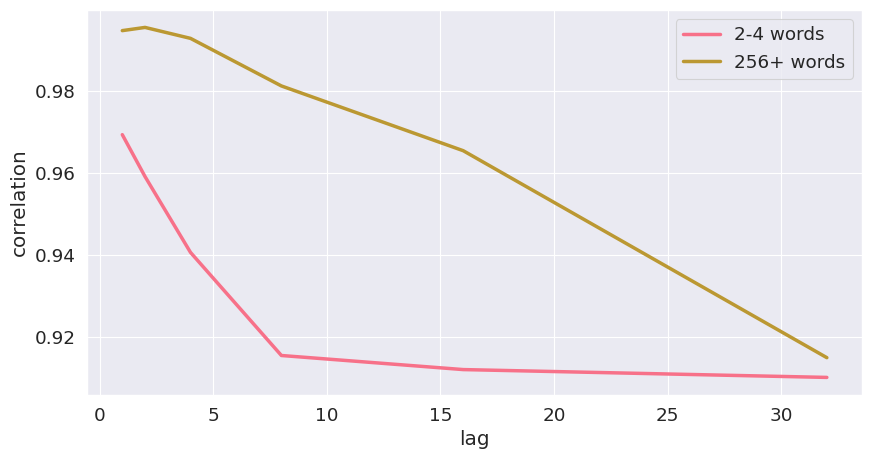

In [38]:
# plot bert vs mbert cosine similarity for different lags

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=correlations_fast, x="lag", y="correlation", ax=ax, label="2-4 words")
sns.lineplot(data=correlations_slow, x="lag", y="correlation", ax=ax, label="256+ words")

ax.set_xlabel("lag")
ax.set_ylabel("correlation")

plt.show()

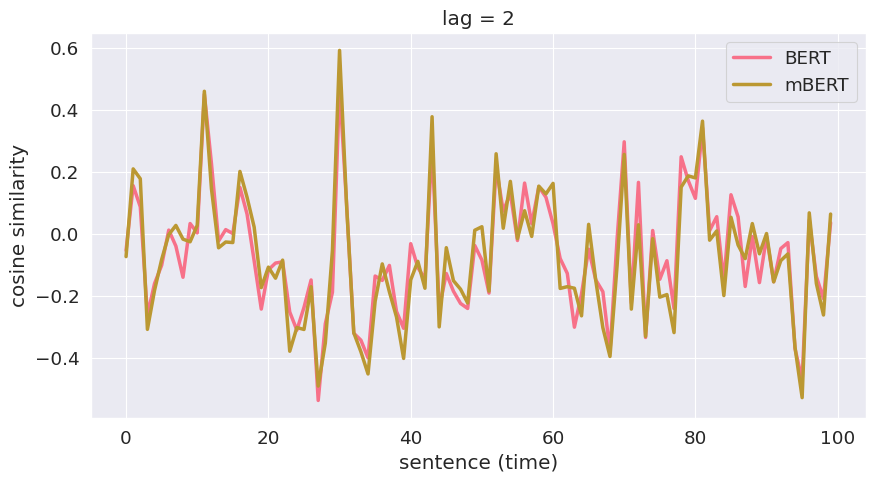

In [40]:
# plot lbert vs mbert cosine similarity time-serires of one of the lags
lag_idx = 1
max_len = 100

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(
    x=range(max_len),
    y=correlations_fast["bert_cosine_similarity"][lag_idx][:max_len],
    ax=ax,
    label="BERT",
)
sns.lineplot(
    x=range(max_len),
    y=correlations_fast["mbert_cosine_similarity"][lag_idx][:max_len],
    ax=ax,
    label="mBERT",
)

ax.set_xlabel("sentence (time)")
ax.set_ylabel("cosine similarity")

ax.set_title("lag = {}".format(correlations_fast["lag"][lag_idx]))

plt.show()

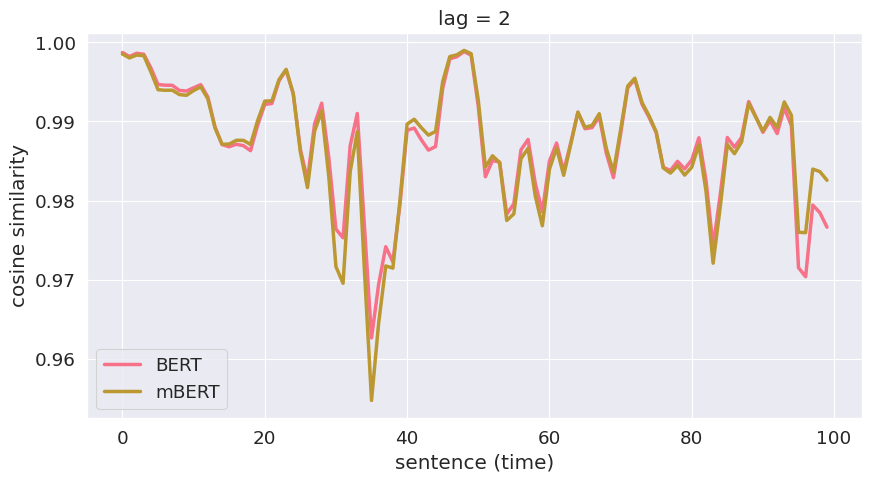

In [41]:
# plot lbert vs mbert cosine similarity time-serires of one of the lags
lag_idx = 1
max_len = 100

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(
    x=range(max_len),
    y=correlations_slow["bert_cosine_similarity"][lag_idx][:max_len],
    ax=ax,
    label="BERT",
)
sns.lineplot(
    x=range(max_len),
    y=correlations_slow["mbert_cosine_similarity"][lag_idx][:max_len],
    ax=ax,
    label="mBERT",
)

ax.set_xlabel("sentence (time)")
ax.set_ylabel("cosine similarity")

ax.set_title("lag = {}".format(correlations_fast["lag"][lag_idx]))

plt.show()

In [42]:
correlations_slow.head()

,lag,correlation,bert_cosine_similarity,mbert_cosine_similarity
0,1,0.994825,"[0.999708689214601, 0.9994815340104221, 0.9995...","[0.9994704540867505, 0.9993819954645022, 0.999..."
1,2,0.995608,"[0.9987217061730294, 0.9982186278728861, 0.998...","[0.998528082401224, 0.9980332077614137, 0.9984..."
2,4,0.992936,"[0.9947000917191197, 0.993477772150947, 0.9911...","[0.9938683359181173, 0.9927733467895896, 0.989..."
3,8,0.981323,"[0.9590241692156333, 0.9488938724346687, 0.940...","[0.9532178949419842, 0.943244177762644, 0.9332..."
4,16,0.965514,"[0.7133539834394549, 0.6709959757349451, 0.635...","[0.6919813120269251, 0.6530266676809755, 0.617..."
